In [228]:
%load_ext autoreload
%autoreload 2
import numpy as np
from juno import utils
from pprint import pprint
from juno.juno_custom.elements.Herschel.structures import HerschelSettings, HerschelSimSettings

from LightPipes import *

from juno.juno_custom.tools import sim_tools
import juno.juno_custom.elements.Herschel.utils as h_utils
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [229]:
config = utils.load_yaml_config(config_filename=r'C:\Users\User\Github\juno\juno\juno_custom\configna488.yaml')
settings = HerschelSettings.from_dict(config.get('HerschelSettings'))
sim_settings = HerschelSimSettings.from_dict(config.get('HerschelSimSettings'))
wavelength = sim_settings.wavelength
pixel_size= wavelength * 0.5
# media_wavelength = wavelength / 2
# pixel_size = media_wavelength * 0.5

In [230]:
settings.calculate_radii(pixel_size=pixel_size)
raw_profiles = h_utils.create_raw_profiles(settings)
profiles = h_utils.calculate_profiles(settings, raw_profiles, pixel_size)
lenses = h_utils.generate_lenses(settings, profiles)
padded_lenses = h_utils.calculate_padding(profiles=profiles, lenses=lenses, settings=settings, sim_settings=sim_settings, pixel_size=pixel_size)

In [231]:
sim_lens, sim_lens_padding = sim_tools.generate_sim_lens(settings, sim_settings, pixel_size)
sim_lens.profile = sim_lens.profile.max() - sim_lens.profile
sim_wavefront = sim_tools.generate_sim_wavefront(sim_lens=sim_lens, sim_lens_padding=sim_lens_padding, settings=settings, sim_settings=sim_settings)

In [232]:
start = -settings.z_medium_o * 0.95
stop = -settings.z_medium_o * 1.05
start = -settings.z_medium_o * 0
stop = -settings.z_medium_o * 2
start = -settings.z_medium_o * -1#-1.1
stop = -settings.z_medium_o * 0
# start = -settings.z_medium_o * 0#-1.1
# stop = -settings.z_medium_o * 2

step = (stop-start)/(100-1)
distances = np.arange(start, stop, step)
distances = np.append(distances, stop)
output, propagation, output_array = sim_tools.propagate_zero_lens(wavefront=sim_wavefront, 
                                                settings=settings,
                                                sim_settings=sim_settings, 
                                                distances=distances,
                                                pixel_size=pixel_size)

In [233]:
print(propagation.shape)

(1, 1819)


In [234]:
# repeat propagation to be square
propagation = np.repeat(propagation, propagation.shape[1], axis=0)
print(propagation.shape)

(1819, 1819)


In [235]:
first_wavefront = sim_tools.generate_lens_first_wavefront(lenses=padded_lenses, settings=settings, sim_settings=sim_settings)
first_wavefront = np.repeat(first_wavefront, propagation.shape[1], axis=0)
print(first_wavefront.shape)

(1819, 1819)


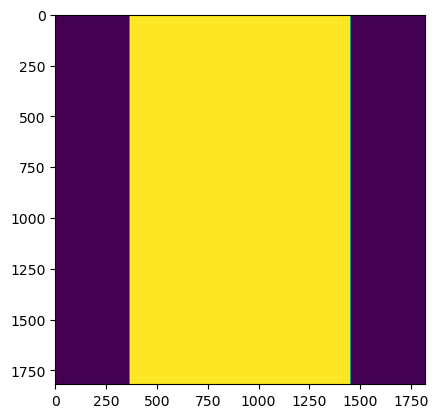

In [236]:
combined_wavefront = propagation * first_wavefront
plt.imshow(np.abs(combined_wavefront)**2)

1819
(1819, 1819)
(1819, 1819)


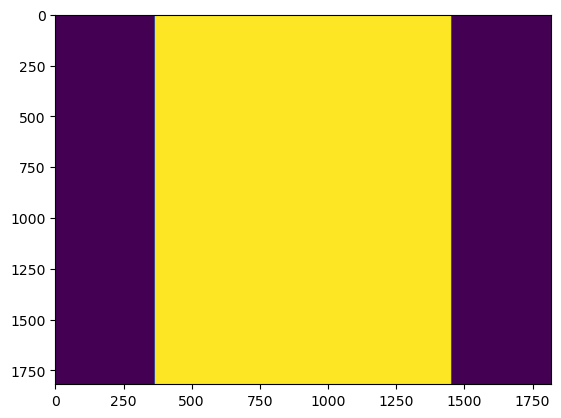

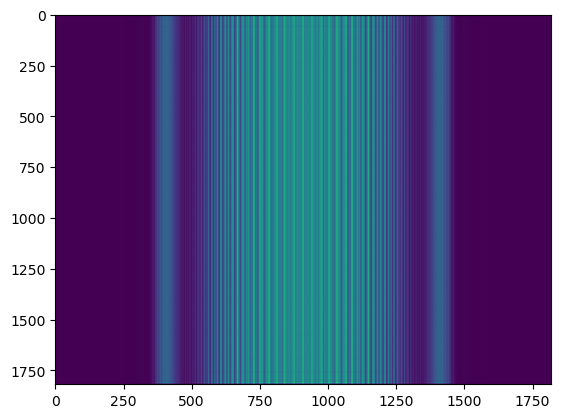

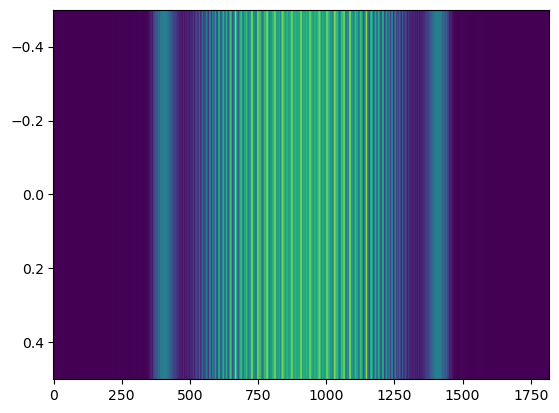

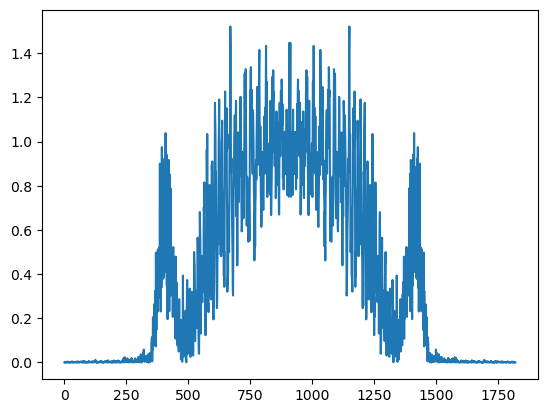

In [237]:
grid_dimension = propagation.shape[1]
print(grid_dimension)
print(propagation.shape)

grid_size = grid_dimension * pixel_size
media_wavelength = wavelength / 2
Field = Begin(grid_size, media_wavelength, grid_dimension)
Field.field = combined_wavefront
I_field = Intensity(0, Field)

print(I_field.shape)
plt.imshow(I_field, aspect='auto')
plt.show()

Field_fresnel = Fresnel(Field, 1*m)
I_field_fresnel = Intensity(0, Field_fresnel)
plt.imshow(I_field_fresnel, aspect='auto')
plt.show()

middle = I_field_fresnel[I_field_fresnel.shape[0]//2:I_field_fresnel.shape[0]//2+1, :]

plt.imshow(middle, aspect='auto')
plt.show()

middle_slice = middle[0, :]
plt.plot(middle_slice)
    

In [239]:
start = 0
stop = settings.thickness
step = (stop-start)/(50-1)
distances = np.arange(start, stop, step)
distances = np.append(distances, stop)
distances = [stop]
# print(distances[-1])

output_array = np.zeros((len(distances), I_field.shape[1]))

for distance in distances:
    print(distance)
    new_Field = Fresnel(Field, distance * m)
    middle_intensity = Intensity(0, new_Field)
    middle = middle_intensity[Field.field.shape[0]//2:Field.field.shape[0]//2+1, :]
    output_array[distances==distance, :] = middle
    # I_field = Intensity(0, Field)
    # plt.imshow(I_field, aspect='auto')
    # plt.show()
# output, propagation, output_array = sim_tools.propagate_zero_lens(wavefront=sim_wavefront, 
#                                                 settings=settings,
#                                                 sim_settings=sim_settings, 
#                                                 distances=distances,
#                                                 pixel_size=pixel_size)
    

15.0


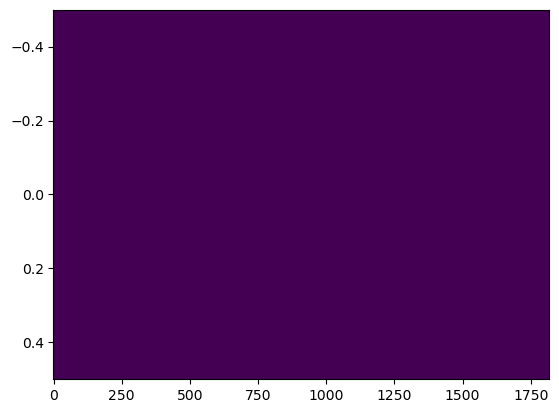

In [240]:
plt.imshow(output_array, aspect='auto')


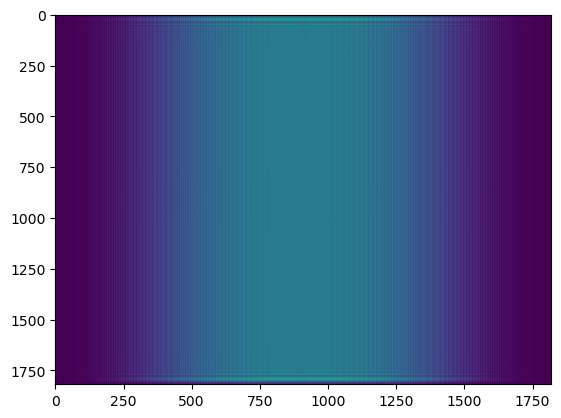

In [241]:
new_intensity = Intensity(0, new_Field)
plt.imshow(new_intensity, aspect='auto')

In [242]:
wavefront_second = sim_tools.generate_lens_second_wavefront(lenses=padded_lenses, settings=settings, sim_settings=sim_settings)


In [243]:
new_propagation = wavefront_second * new_Field.field

In [261]:
start = 55
stop = 65
step = (stop-start)/(50-1)
distances = np.arange(start, stop, step)
distances = np.append(distances, stop)
# distances = [stop]
wavelength = sim_settings.wavelength
# print(f"Step: {step}")
# output3, propagation3, output_array3 = sim_tools.propagate_second_lens(previous_wavefront=None, wavefront=new_propagation, settings=settings, distances=distances, sim_settings=sim_settings, pixel_size=pixel_size)
Field = Begin(grid_size, wavelength, grid_dimension)
Field.field = new_propagation

In [262]:
# start = 0
# stop = settings.thickness
# step = (stop-start)/(50-1)
# distances = np.arange(start, stop, step)
# distances = np.append(distances, stop)
# print(distances[-1])

output_array = np.zeros((len(distances), I_field.shape[1]))

for distance in distances:
    print(distance)
    new_Field = Fresnel(Field, distance * m)
    middle_intensity = Intensity(0, new_Field)
    middle = middle_intensity[Field.field.shape[0]//2:Field.field.shape[0]//2+1, :]
    output_array[distances==distance, :] = middle
    # I_field = Intensity(0, Field)
    # plt.imshow(I_field, aspect='auto')
    # plt.show()
# output, propagation, output_array = sim_tools.propagate_zero_lens(wavefront=sim_wavefront, 
#                                                 settings=settings,
#                                                 sim_settings=sim_settings, 
#                                                 distances=distances,
#                                                 pixel_size=pixel_size)
    

55.0


55.204081632653065
55.40816326530613
55.612244897959194
55.81632653061226
56.02040816326532
56.22448979591839
56.42857142857145
56.63265306122452
56.83673469387758
57.040816326530646
57.24489795918371
57.448979591836775
57.65306122448984
57.857142857142904
58.06122448979597
58.26530612244903
58.4693877551021
58.67346938775516
58.87755102040823
59.08163265306129
59.285714285714356
59.48979591836742
59.693877551020485
59.89795918367355
60.102040816326614
60.30612244897968
60.51020408163274
60.71428571428581
60.91836734693887
61.12244897959194
61.326530612245
61.530612244898066
61.73469387755113
61.938775510204195
62.14285714285726
62.346938775510324
62.55102040816339
62.75510204081645
62.95918367346952
63.16326530612258
63.36734693877565
63.57142857142871
63.775510204081776
63.97959183673484
64.18367346938791
64.38775510204097
64.59183673469403
64.7959183673471
65.0


In [263]:
# tart = 40
# stop = 80
# step = (stop-start)/(1000-1)
# distances = np.arange(start, stop, step)
# distances = np.append(distances, stop)
# print(f"Step: {step}")
# output3, propagation3, output_array3 = sim_tools.propagate_second_lens(previous_wavefront=propagation2, wavefront=wavefront_second, settings=settings, distances=distances, sim_settings=sim_settings, pixel_size=pixel_size)


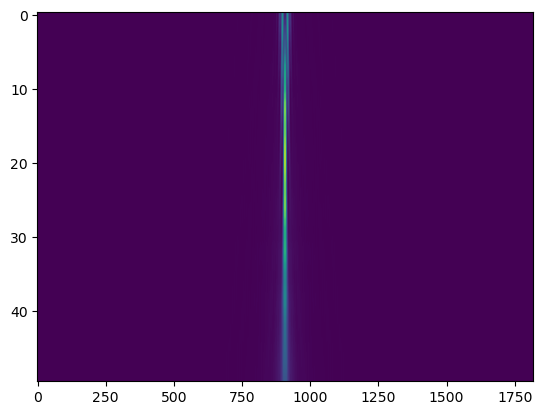

In [264]:
plt.imshow(output_array, aspect='auto')


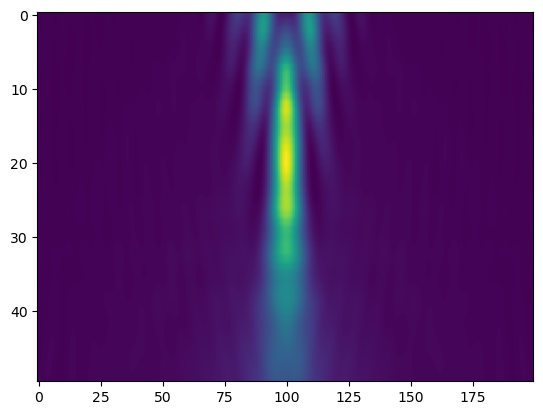

In [268]:
cy = output_array.shape[0]//2
cx = output_array.shape[1]//2

width = 200

zoomed_array = output_array[:, cx-width//2:cx+width//2]
# zoomed_array = output_array3[100:140, cx-width//2:cx+width//2]
plt.imshow(zoomed_array, aspect='auto')

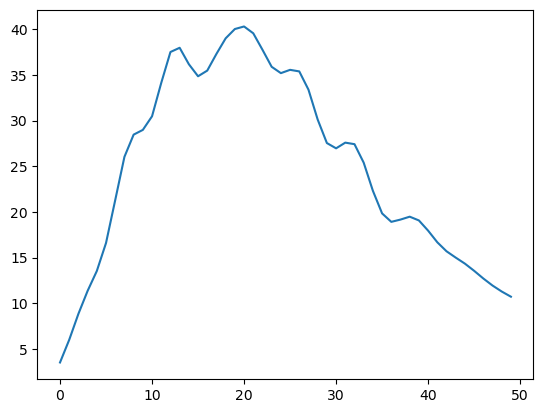

In [269]:
central_line = zoomed_array[:, width//2]
plt.plot(central_line)
halfmax = np.max(central_line)/2

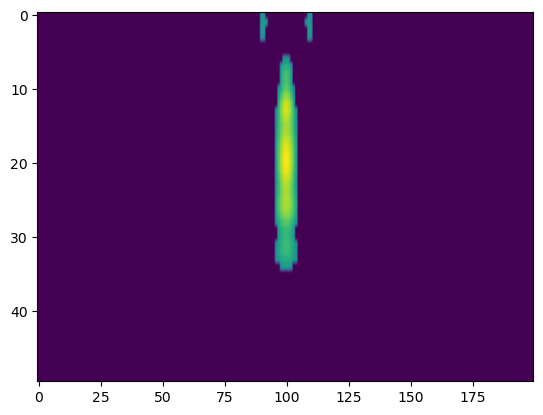

In [270]:
# halfmax = np.max(zoomed_array)/2
zoomed_binary = zoomed_array > halfmax
zoomed_halfmax = zoomed_array*zoomed_binary
plt.imshow(zoomed_halfmax, aspect='auto')

In [271]:
from juno.lightsheet import light_sheet

6.122448979591837
0.165


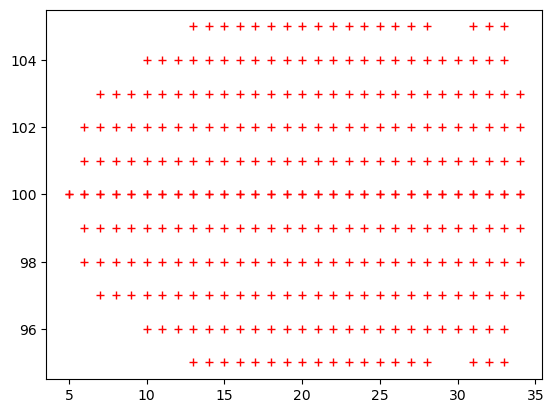

In [272]:
len_px, wid_px, (x, y) = light_sheet.calculate_sheet_size_pixels(zoomed_halfmax, 0.5)
print(len_px * step)
print(wid_px * pixel_size)
plt.plot(x, y, 'r+')